#Library

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
import shutil
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Dataset

In [ ]:
sdir = '/content/drive/MyDrive/project mining/Batik'
os.chdir(sdir)
print(os.listdir('.'))

filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

['batik-tambal', 'batik-parang', 'batik-cendrawasih', 'batik-bali', 'batik-lasem', 'batik-dayak', 'batik-celup', 'batik-kawung', 'batik-megamendung', 'batik-betawi', 'MobileNet-V2-Batik bismillah-66.39.h5', 'MobileNet-V2-Batik bismillah-75.19.h5', 'MobileNet-V2-Batik bismillah-76.80.h5', 'MobileNet-V2-Batik bismillah-77.99.h5', 'MobileNet-V2-Batik bismillah-73.60.h5', 'MobileNet-V2-Batik bismillah-75.99.h5', 'MobileNet-V2-Batik bismillah-77.20.h5', 'MobileNet-V2-Batik bismillah-78.39.h5', 'MobileNet-V2-Batik bismillah-77.60.h5', 'Batik bismillah-10.txt']
                                           filepaths        labels
0  /content/drive/MyDrive/project mining/Batik/ba...  batik-tambal
1  /content/drive/MyDrive/project mining/Batik/ba...  batik-tambal
2  /content/drive/MyDrive/project mining/Batik/ba...  batik-tambal
3  /content/drive/MyDrive/project mining/Batik/ba...  batik-tambal
4  /content/drive/MyDrive/project mining/Batik/ba...  batik-tambal
labels
batik-tambal         250
batik

#Pre-processing

##Split dataset

In [ ]:
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  2000   test_df length:  250   valid_df length:  250


##Augmentasi

In [ ]:
height=224
width=224
channels=3
batch_size=20

img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

def mobilenetv2_preprocess(img):
    # return img/127.5-1 # scale pixel between -1 and +1
    return tf.keras.applications.mobilenet_v2.preprocess_input(img)

train_aug = ImageDataGenerator(
    preprocessing_function=mobilenetv2_preprocess,
    #rescale=1/255.0,
    shear_range=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

test_aug = ImageDataGenerator(
    preprocessing_function=mobilenetv2_preprocess,
    #rescale=1/255.0,
    shear_range=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',

)

train_gen=train_aug.flow_from_dataframe( train_df,
                                  x_col='filepaths',
                                  y_col='labels',
                                  target_size=img_size,
                                  class_mode='categorical',
                                  color_mode='rgb',
                                  shuffle=True,
                                  batch_size=batch_size)
test_gen=test_aug.flow_from_dataframe( test_df,
                                     x_col='filepaths',
                                     y_col='labels', target_size=img_size, class_mode='categorical',
                                     color_mode='rgb',
                                     shuffle=False,
                                     batch_size=test_batch_size)
valid_gen=train_aug.flow_from_dataframe( valid_df,
                                       x_col='filepaths',
                                       y_col='labels',
                                       target_size=img_size,
                                       class_mode='categorical',
                                       color_mode='rgb',
                                       shuffle=True,
                                       batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)



test batch size:  50   test steps:  5
Found 2000 validated image filenames belonging to 10 classes.
Found 250 validated image filenames belonging to 10 classes.
Found 250 validated image filenames belonging to 10 classes.
['batik-bali', 'batik-betawi', 'batik-celup', 'batik-cendrawasih', 'batik-dayak', 'batik-kawung', 'batik-lasem', 'batik-megamendung', 'batik-parang', 'batik-tambal']


##Tampilkan img

In [ ]:
def show_image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=(images[i]+1)/2
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

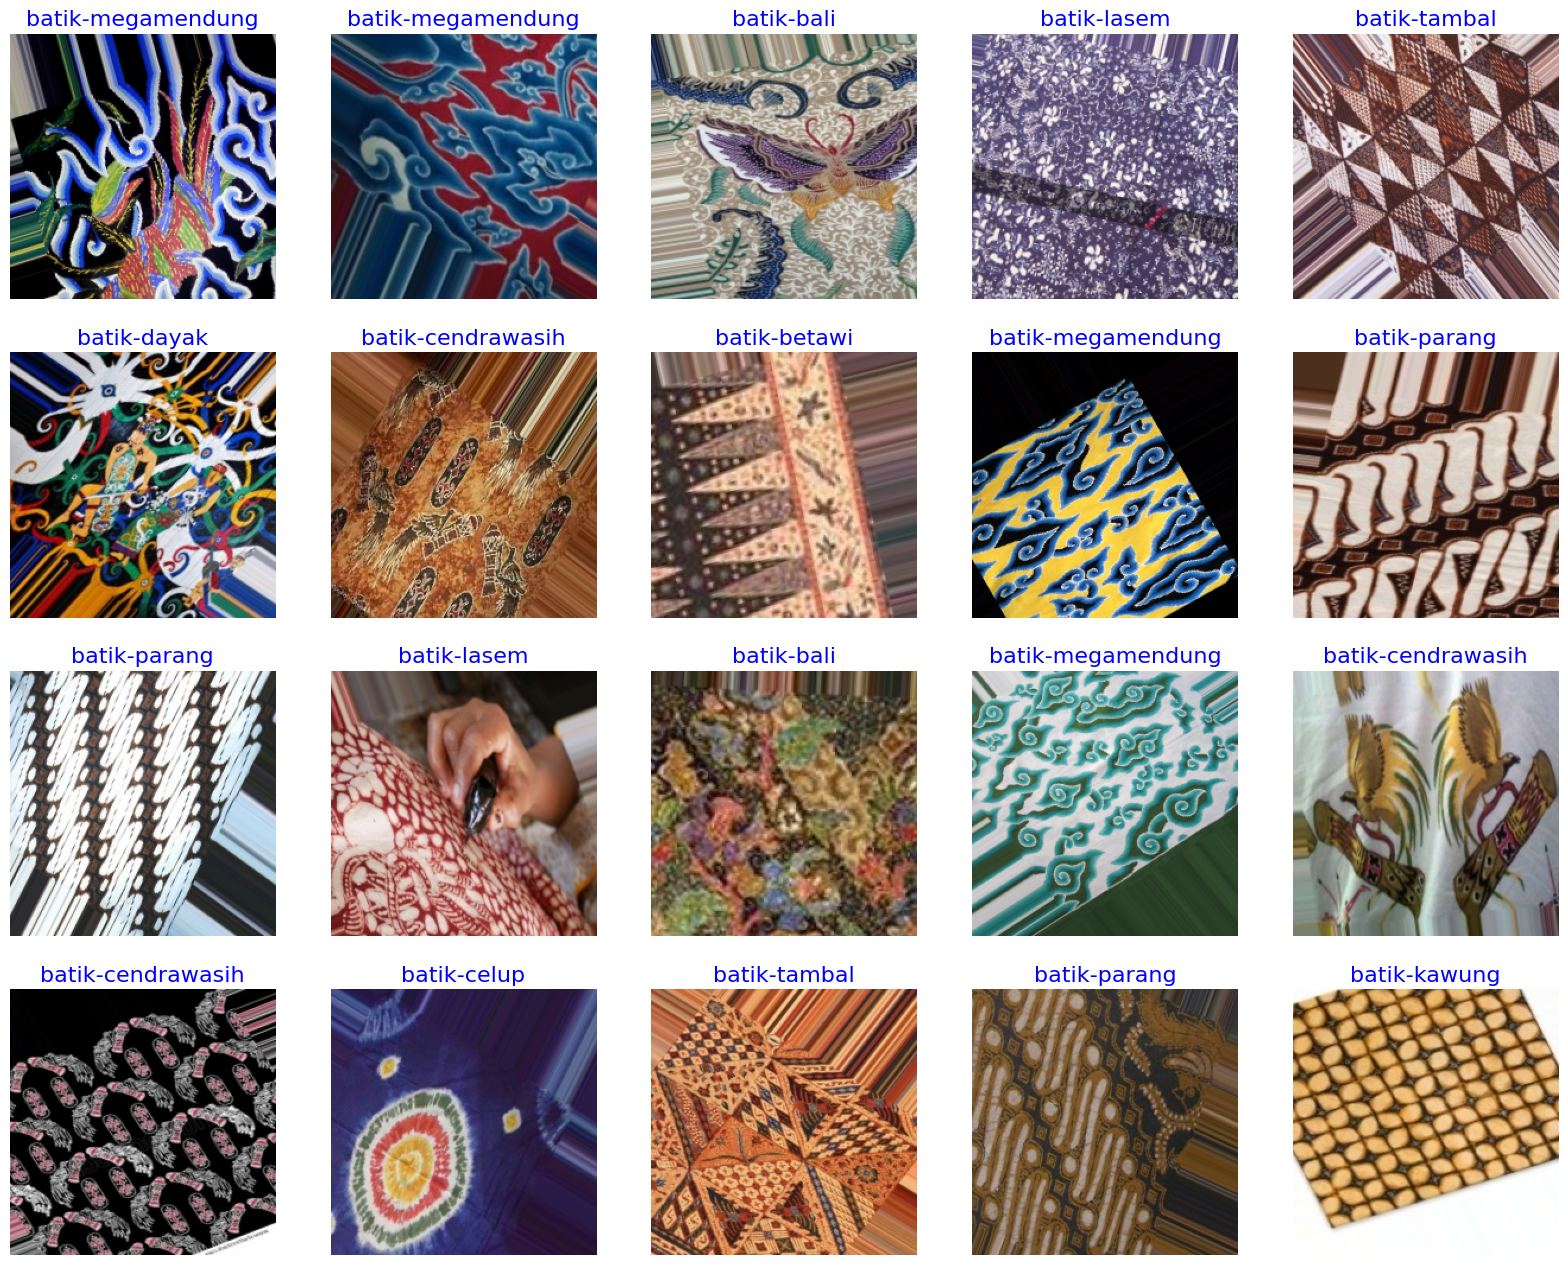

In [ ]:
show_image_samples(train_gen)

#Bangun model

In [ ]:
base_model=tf.keras.applications.MobileNetV2(include_top=False, weights="imagenet",input_shape=img_shape)
base_model.trainable = False

#MobileNetV2
model_MobileNetV2 = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(class_count, activation='softmax')
])

model_MobileNetV2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [ ]:
model_MobileNetV2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 32)          368672    
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 32)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 3, 3, 32)          0         
                                                                 
 flatten (Flatten)           (None, 288)               0         
                                                                 
 dense (Dense)               (None, 10)                2

###Training

In [ ]:
model_name= 'MobileNetV2'

history_MobileNetV2 = model_MobileNetV2.fit(x=train_gen, epochs=50, verbose=1, validation_data=valid_gen, initial_epoch=0)

Epoch 1/50
100/100 [==============================] - 662s 7s/step - loss: 2.1691 - accuracy: 0.2460 - val_loss: 1.7094 - val_accuracy: 0.4280
Epoch 2/50
100/100 [==============================] - 142s 1s/step - loss: 1.7713 - accuracy: 0.3730 - val_loss: 1.4757 - val_accuracy: 0.5600
Epoch 3/50
100/100 [==============================] - 142s 1s/step - loss: 1.5081 - accuracy: 0.4810 - val_loss: 1.2612 - val_accuracy: 0.6040
Epoch 4/50
100/100 [==============================] - 147s 1s/step - loss: 1.2759 - accuracy: 0.5765 - val_loss: 1.2159 - val_accuracy: 0.6040
Epoch 5/50
100/100 [==============================] - 139s 1s/step - loss: 1.1534 - accuracy: 0.6280 - val_loss: 0.9655 - val_accuracy: 0.6960
Epoch 6/50
100/100 [==============================] - 139s 1s/step - loss: 1.0531 - accuracy: 0.6690 - val_loss: 1.0510 - val_accuracy: 0.7160
Epoch 7/50
100/100 [==============================] - 141s 1s/step - loss: 0.9825 - accuracy: 0.7105 - val_loss: 0.9490 - val_accuracy: 0.6800

##Tampilan grafik

In [ ]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

In [ ]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'
    dict_path=os.path.join(save_dir,dict_name)
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)
    errors=0
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors=errors + 1
        y_pred.append(pred_index)
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                split1=os.path.split(error_list[i])
                split2=os.path.split(split1[0])
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():
            count=error_indices.count(key)
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix
        cm = confusion_matrix(y_true, y_pred )
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

In [ ]:
save_dir=r'/content/drive/MyDrive/project mining/Batik'
subject='Batik_model'

MobileNet-V2


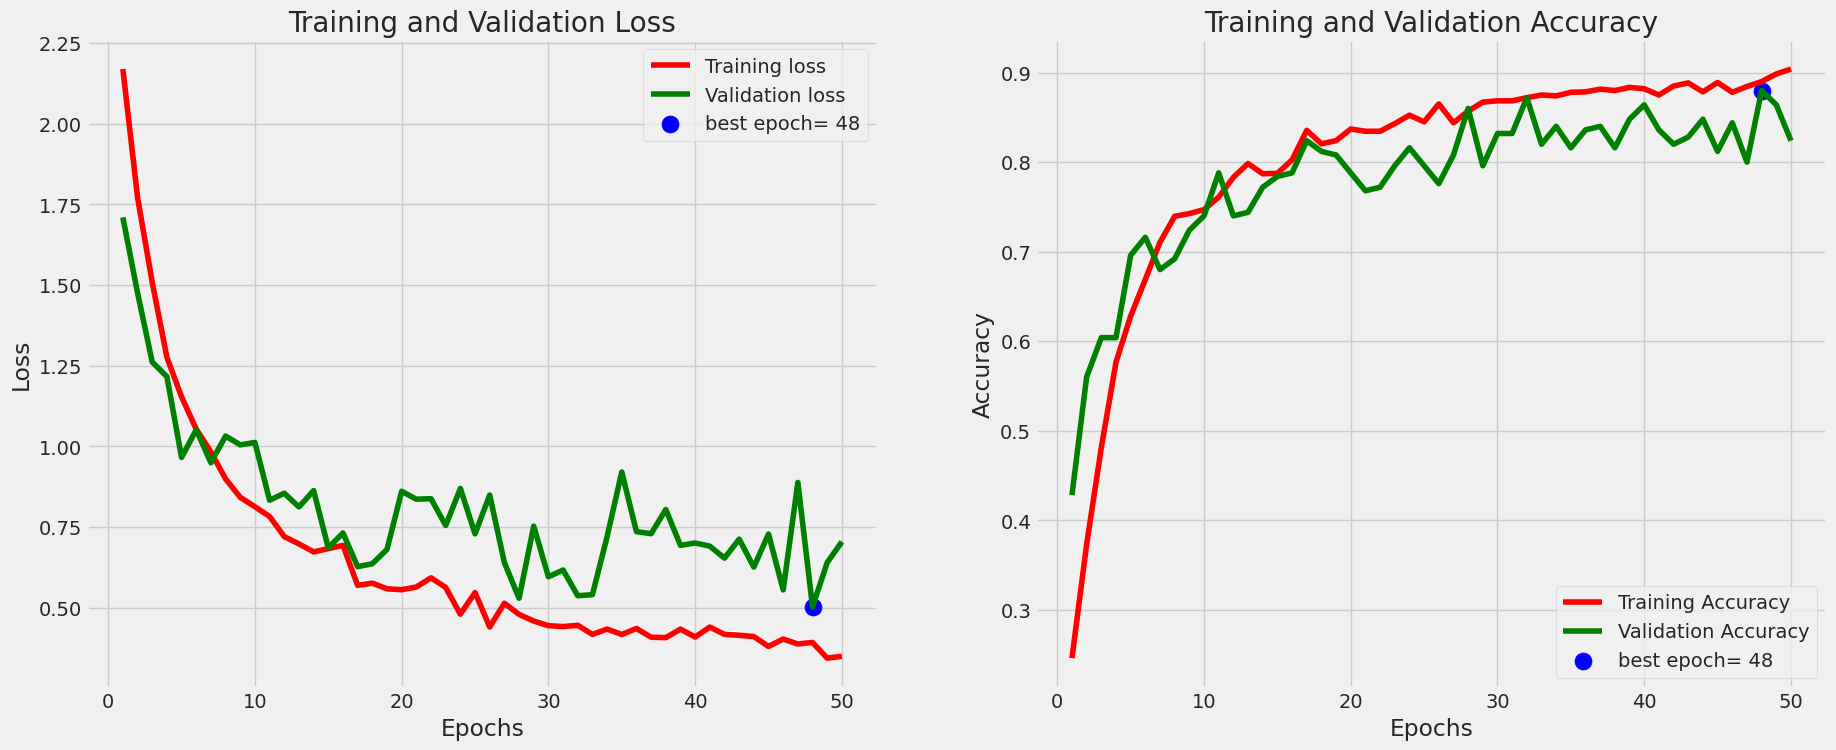

5/5 [==============================] - 17s 3s/step - loss: 0.6558 - accuracy: 0.8480
accuracy on the test set is 84.80 %



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model_name= 'MobileNet-V2'
print(model_name)
tr_plot(history_MobileNetV2,0)
acc_MobileNetV2=model_MobileNetV2.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc_MobileNetV2:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_name +  '-' + subject +'-'+ str(acc_MobileNetV2)[:str(acc_MobileNetV2).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model_MobileNetV2.save(save_loc)

5/5 [==============================] - 16s 3s/step


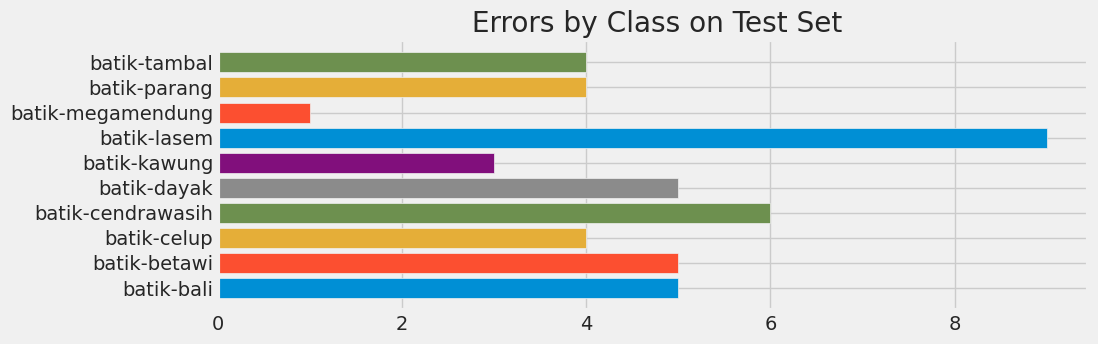

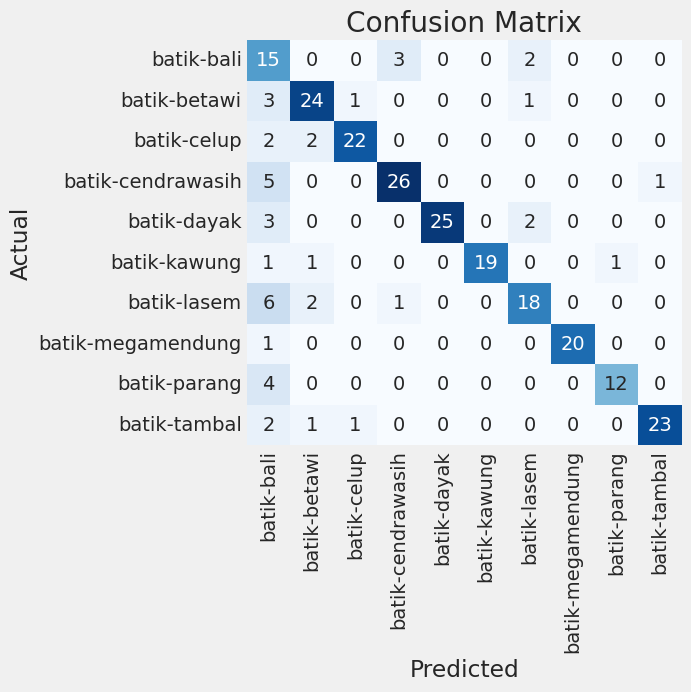

Classification Report:
----------------------
                    precision    recall  f1-score   support

       batik-bali       0.36      0.75      0.48        20
     batik-betawi       0.80      0.83      0.81        29
      batik-celup       0.92      0.85      0.88        26
batik-cendrawasih       0.87      0.81      0.84        32
      batik-dayak       1.00      0.83      0.91        30
     batik-kawung       1.00      0.86      0.93        22
      batik-lasem       0.78      0.67      0.72        27
batik-megamendung       1.00      0.95      0.98        21
     batik-parang       0.92      0.75      0.83        16
     batik-tambal       0.96      0.85      0.90        27

         accuracy                           0.82       250
        macro avg       0.86      0.82      0.83       250
     weighted avg       0.87      0.82      0.83       250



In [ ]:
print_code=0
preds=model_MobileNetV2.predict(test_gen)
print_info(test_gen, preds, print_code, save_dir, subject)

#Evaluasi

Saving clp.jpeg to clp.jpeg
1/1 [==============================] - 1s 1s/step


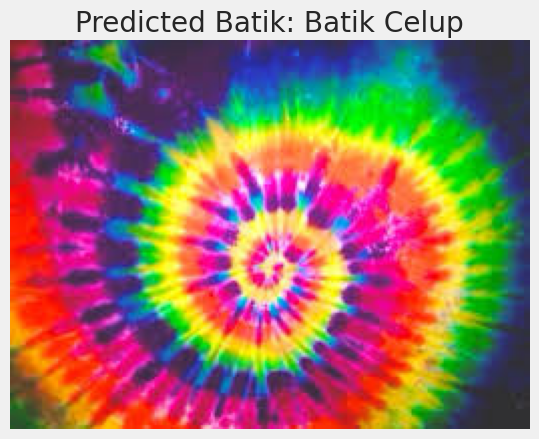

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import files
from IPython.display import Image, display

# Load the pre-trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/project mining/Batik/MobileNet-V2-Batik bismillah-83.99.h5')

# List of batik names corresponding to the classes
batik_names = ['Batik Bali', 'Batik Betawi', 'Batik Celup', 'Batik Cendrawasih',
               'Batik Dayak', 'Batik Kawung', 'Batik Lasem', 'Batik Megamendung',
               'Batik Parang', 'Batik Tambal']

# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    # Read the image using OpenCV
    img = cv2.imread(image_path)

    # Convert the image to RGB (OpenCV uses BGR by default)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize the image to match the input size of the model (224x224)
    img = cv2.resize(img, (224, 224))

    # Normalize pixel values to the range [0, 1]
    img = img / 255.0

    # Add batch dimension
    img = np.expand_dims(img, axis=0)

    return img

# Function to make a prediction
def predict_image(model, image):
    # Make a prediction
    predictions = model.predict(image)

    # Get the index of the class with the highest probability
    predicted_class = np.argmax(predictions, axis=1)

    return predicted_class

# Function to display the image with the prediction
def display_image_with_prediction(image_path, predicted_class):
    # Read the image using OpenCV
    img = cv2.imread(image_path)

    # Convert the image to RGB (OpenCV uses BGR by default)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image using Matplotlib
    plt.imshow(img)
    plt.title(f'Predicted Batik: {batik_names[predicted_class[0]]}')
    plt.axis('off')
    plt.show()

# Upload image files
uploaded = files.upload()

# Process each uploaded image
for filename in uploaded.keys():
    # Save the uploaded file to disk
    with open(filename, 'wb') as f:
        f.write(uploaded[filename])

    # Load and preprocess the image
    img = load_and_preprocess_image(filename)

    # Make a prediction
    predicted_class = predict_image(model, img)

    # Display the image and the prediction result
    display_image_with_prediction(filename, predicted_class)


Saving kwng.jpeg to kwng.jpeg


1/1 [==============================] - 1s 931ms/step


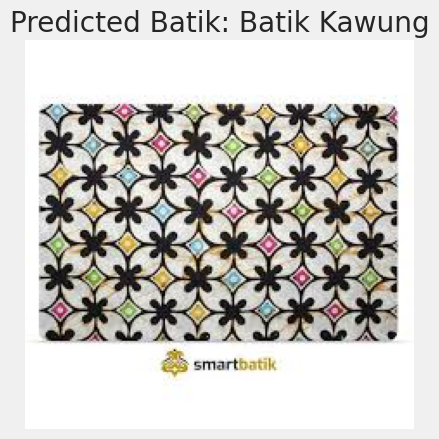

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import files
from IPython.display import Image, display

# Load the pre-trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/project mining/Batik/MobileNet-V2-Batik bismillah-83.99.h5')

# List of batik names corresponding to the classes
batik_names = ['Batik Bali', 'Batik Betawi', 'Batik Celup', 'Batik Cendrawasih',
               'Batik Dayak', 'Batik Kawung', 'Batik Lasem', 'Batik Megamendung',
               'Batik Parang', 'Batik Tambal']

# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    # Read the image using OpenCV
    img = cv2.imread(image_path)

    # Convert the image to RGB (OpenCV uses BGR by default)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize the image to match the input size of the model (224x224)
    img = cv2.resize(img, (224, 224))

    # Normalize pixel values to the range [0, 1]
    img = img / 255.0

    # Add batch dimension
    img = np.expand_dims(img, axis=0)

    return img

# Function to make a prediction
def predict_image(model, image):
    # Make a prediction
    predictions = model.predict(image)

    # Get the index of the class with the highest probability
    predicted_class = np.argmax(predictions, axis=1)

    return predicted_class

# Function to display the image with the prediction
def display_image_with_prediction(image_path, predicted_class):
    # Read the image using OpenCV
    img = cv2.imread(image_path)

    # Convert the image to RGB (OpenCV uses BGR by default)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image using Matplotlib
    plt.imshow(img)
    plt.title(f'Predicted Batik: {batik_names[predicted_class[0]]}')
    plt.axis('off')
    plt.show()

# Upload image files
uploaded = files.upload()

# Process each uploaded image
for filename in uploaded.keys():
    # Save the uploaded file to disk
    with open(filename, 'wb') as f:
        f.write(uploaded[filename])

    # Load and preprocess the image
    img = load_and_preprocess_image(filename)

    # Make a prediction
    predicted_class = predict_image(model, img)

    # Display the image and the prediction result
    display_image_with_prediction(filename, predicted_class)


Saving (206).jpg to (206).jpg
1/1 [==============================] - 1s 924ms/step


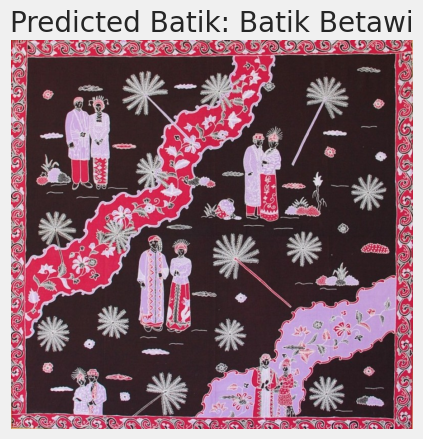

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import files
from IPython.display import Image, display

# Load the pre-trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/project mining/Batik/MobileNet-V2-Batik bismillah-83.99.h5')

# List of batik names corresponding to the classes
batik_names = ['Batik Bali', 'Batik Betawi', 'Batik Celup', 'Batik Cendrawasih',
               'Batik Dayak', 'Batik Kawung', 'Batik Lasem', 'Batik Megamendung',
               'Batik Parang', 'Batik Tambal']

# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    # Read the image using OpenCV
    img = cv2.imread(image_path)

    # Convert the image to RGB (OpenCV uses BGR by default)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize the image to match the input size of the model (224x224)
    img = cv2.resize(img, (224, 224))

    # Normalize pixel values to the range [0, 1]
    img = img / 255.0

    # Add batch dimension
    img = np.expand_dims(img, axis=0)

    return img

# Function to make a prediction
def predict_image(model, image):
    # Make a prediction
    predictions = model.predict(image)

    # Get the index of the class with the highest probability
    predicted_class = np.argmax(predictions, axis=1)

    return predicted_class

# Function to display the image with the prediction
def display_image_with_prediction(image_path, predicted_class):
    # Read the image using OpenCV
    img = cv2.imread(image_path)

    # Convert the image to RGB (OpenCV uses BGR by default)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image using Matplotlib
    plt.imshow(img)
    plt.title(f'Predicted Batik: {batik_names[predicted_class[0]]}')
    plt.axis('off')
    plt.show()

# Upload image files
uploaded = files.upload()

# Process each uploaded image
for filename in uploaded.keys():
    # Save the uploaded file to disk
    with open(filename, 'wb') as f:
        f.write(uploaded[filename])

    # Load and preprocess the image
    img = load_and_preprocess_image(filename)

    # Make a prediction
    predicted_class = predict_image(model, img)

    # Display the image and the prediction result
    display_image_with_prediction(filename, predicted_class)


Saving kwg.jpeg to kwg (2).jpeg
1/1 [==============================] - 2s 2s/step


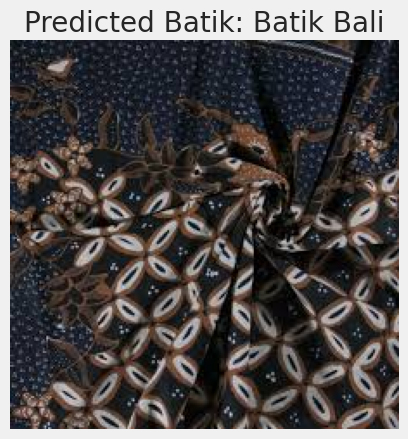

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import files
from IPython.display import Image, display

# Load the pre-trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/project mining/Batik/MobileNet-V2-Batik bismillah-83.99.h5')

# List of batik names corresponding to the classes
batik_names = ['Batik Bali', 'Batik Betawi', 'Batik Celup', 'Batik Cendrawasih',
               'Batik Dayak', 'Batik Kawung', 'Batik Lasem', 'Batik Megamendung',
               'Batik Parang', 'Batik Tambal']

# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    # Read the image using OpenCV
    img = cv2.imread(image_path)

    # Convert the image to RGB (OpenCV uses BGR by default)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize the image to match the input size of the model (224x224)
    img = cv2.resize(img, (224, 224))

    # Normalize pixel values to the range [0, 1]
    img = img / 255.0

    # Add batch dimension
    img = np.expand_dims(img, axis=0)

    return img

# Function to make a prediction
def predict_image(model, image):
    # Make a prediction
    predictions = model.predict(image)

    # Get the index of the class with the highest probability
    predicted_class = np.argmax(predictions, axis=1)

    return predicted_class

# Function to display the image with the prediction
def display_image_with_prediction(image_path, predicted_class):
    # Read the image using OpenCV
    img = cv2.imread(image_path)

    # Convert the image to RGB (OpenCV uses BGR by default)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image using Matplotlib
    plt.imshow(img)
    plt.title(f'Predicted Batik: {batik_names[predicted_class[0]]}')
    plt.axis('off')
    plt.show()

# Upload image files
uploaded = files.upload()

# Process each uploaded image
for filename in uploaded.keys():
    # Save the uploaded file to disk
    with open(filename, 'wb') as f:
        f.write(uploaded[filename])

    # Load and preprocess the image
    img = load_and_preprocess_image(filename)

    # Make a prediction
    predicted_class = predict_image(model, img)

    # Display the image and the prediction result
    display_image_with_prediction(filename, predicted_class)


1/1 [==============================] - 1s 624ms/step


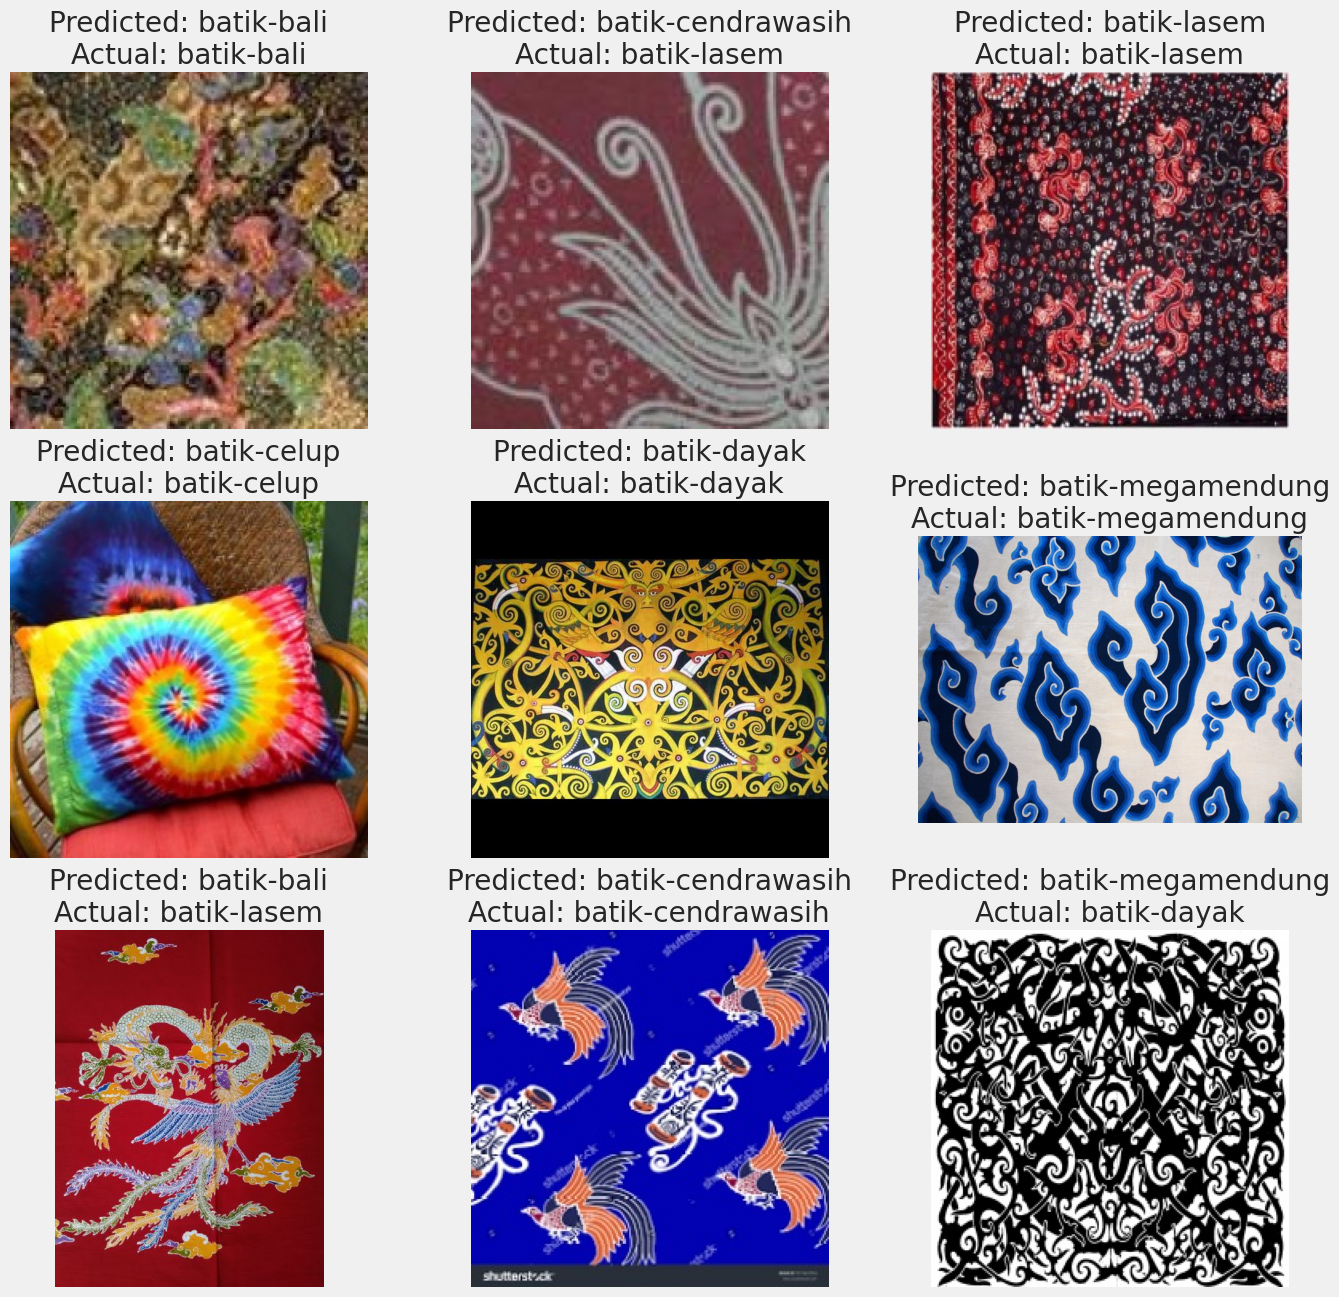

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.preprocessing import LabelEncoder

# Inisialisasi label encoder dan fit pada label dataset
le = LabelEncoder()
le.fit(train_df['labels'])  # atau test_df['labels'], tergantung dataset yang tersedia

# Mendefinisikan ukuran gambar yang digunakan dalam model
IMG_SIZE = (224, 224)  # Sesuaikan dengan ukuran input model

# Fungsi untuk memproses gambar
def load_and_process_image(image_path, img_size):
    # Memuat gambar
    img = load_img(image_path, target_size=img_size)
    # Mengubah gambar menjadi array numpy
    img_array = img_to_array(img)
    # Menormalisasi gambar
    img_array = img_array / 255.0
    # Menambahkan dimensi batch (jumlah_gambar, tinggi, lebar, saluran_warna)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Mendapatkan sampel acak dari 9 gambar dari set uji
test_image_indices = random.sample(range(len(test_df)), 9)
test_images = [load_and_process_image(test_df.iloc[i]['filepaths'], IMG_SIZE) for i in test_image_indices]
test_image_paths = [test_df.iloc[i]['filepaths'] for i in test_image_indices]

# Menggabungkan semua gambar menjadi satu array
test_images_combined = np.vstack(test_images)

# Prediksi kelas setiap gambar
predicted_labels = model.predict(test_images_combined)
predicted_labels = np.argmax(predicted_labels, axis=1)

# Mendapatkan label aktual dari gambar-gambar tersebut
actual_labels = [test_df.iloc[i]['labels'] for i in test_image_indices]
actual_labels_encoded = le.transform(actual_labels)

# Nama kelas batik
batik_names = le.classes_

# Pastikan prediksi dan label aktual berada dalam rentang yang benar
for pred_label, act_label in zip(predicted_labels, actual_labels_encoded):
    if pred_label >= len(batik_names) or act_label >= len(batik_names):
        print(f"Label prediksi atau aktual keluar dari rentang: Predicted: {pred_label}, Actual: {act_label}")

# Membuat figure dengan 9 subplot
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Iterasi melalui gambar-gambar dan menampilkannya dengan label prediksi dan aktual
for i, (image_path, pred_label, act_label) in enumerate(zip(test_image_paths, predicted_labels, actual_labels_encoded)):
    ax = axes[i // 3, i % 3]
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if pred_label < len(batik_names) and act_label < len(batik_names):
        ax.set_title(f"Predicted: {batik_names[pred_label]}\nActual: {batik_names[act_label]}")
    else:
        ax.set_title("Label out of range")
    ax.axis('off')
    ax.imshow(img)

# Menampilkan figure
plt.show()
